<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp-v2'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
#amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-v4.nc'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
amp_diffs = extract_differentials(amp_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=90)

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# load alignments
aligned_ = pd.read_table(f'{amp_directory}/age_sex_matched_seqs.sam', header=None)
aligned = aligned_[[0, 2]]
aligned.columns = ['ASV', 'GOTU']

In [3]:
# Merge ASVs with GOTUs
aligned = pd.merge(aligned, mapping.reset_index(), left_on='GOTU', right_on='GOTU', how='outer')

In [4]:
# Focus on Bifidobacteria
bifidos = aligned.loc[aligned['genus'] == 'Bifidobacterium']
bifidos = bifidos[['ASV', 'species']]
bifidos = bifidos.sort_values(['species', 'ASV'])
bifidos = bifidos.dropna()
#bifidos = bifidos.drop_duplicates()

In [5]:
tcga = {'T': 0, 'C': 1, 'G': 2, 'A': 3, 'N': 4}

X = np.vstack(bifidos['ASV'].apply(lambda x: [tcga[i] for i in x]).values)
X = pd.DataFrame(X, index=bifidos['species'])

In [6]:
aligned.head()

,ASV,GOTU,genome,kingdom,phylum,class,order,family,genus,species
0,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,G000157955,411471,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,Subdoligranulum variabile
1,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,G000157955,411471,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,Subdoligranulum variabile
2,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,G000157955,411471,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,Subdoligranulum variabile
3,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,G000157955,411471,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,Subdoligranulum variabile
4,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,G000157955,411471,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,Subdoligranulum variabile


<ipython-input-7-145a8ea01fcd>:3: UserWarning: Use the colorbar set_ticks() method instead.
  plt.xticks([])


(None, [])

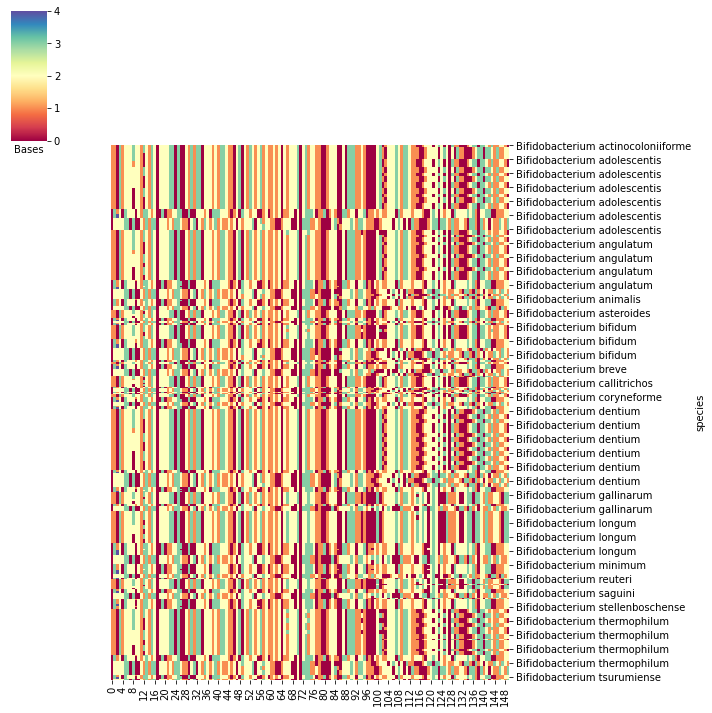

In [7]:
sns.clustermap(X, cmap='Spectral', row_cluster=False, col_cluster=False)
plt.xlabel('Bases')
plt.xticks([])

In [8]:
bifidos = bifidos.reset_index()

In [9]:
asvs = list(set(bifidos['ASV']))
asv_lookup = dict(zip(asvs, list(range(len(asvs)))))
bifidos['ID'] = [asv_lookup[x] for x in bifidos['ASV'].values]

Visualize ASV and genome pairings

In [10]:
from pyvis.network import Network
import networkx as nx

G = nx.convert_matrix.from_pandas_edgelist(
    bifidos, source='ID', target='species')
net = Network(notebook=True)
net.from_nx(G)
net.show('example.html')

Strange bifidobacteria